# Di-nucleotide frequency differences in organisms (Fruit Fly and Human Genome)

## Primary Authors:
1. Gilo, Joshua
2. Go, Daphne Janelyn
3. Lasala, Kyle Carlo

## Objective:
1. To compare the nucleotide and di-nucleotide frequencies in the human and fruit fly genomes
2. To discuss possible biological justifications for the observations

### Introduction
Every genome is composed of the same four nucleotide bases: Adenine (A), Cytosine (C), Guanine (G), and Thymine (T). The key insight which Gentles, Burge and Karlin introduced was the idea of a genomic signature. They defined the genomic signature as the set of dinucleotide odds ratios which remains a stable property of the DNA of an organism, yet remains distinct between species.


A standard assessment of dinucleotide bias is through an odds ratio calculation defined as:
$$ \rho_{xy} = \frac{f_{xy}}{f_x f_y}$$

where:

$f_{xy}$ is the observed frequency of the dinucleotide $xy$

$f_{x}$ and $f_{y}$ are the observed frequencies of nucleotides $x$ and $y$.

By comparing the observed frequency of a given dinucleotide to the product of the individual frequencies of its individual nucleotides (expected frequency), $\rho_{xy}$ describes the chance of a given dinucleotide appearing under the assumption that each nucleotide are chosen independently (zero-order model).

#### The Use of Odd Ratio
We measured both mono- and dinucleotide frequencies in this exercise because:
1. A given genome could have compositional bias. A compositional bias is defined as any deviation from the equal representation of the four bases. In a uniform distribution, it is expected that each nucleotides would appear 25% at a time. However, most genomes tend to deviate from this particular distribution. This deviations could arise from mutational pressures, or could be a consequence of evolution.
2. The zero-order model provides a baseline for detecting higher-order dependencies. This model treats each base as if they were picked at random, only based on how common that base is overall without giving any attention to its adjacent nucleotides. Under this assumption, the chance of seeing two bases together is simply the product of their individual frequencies.
- If the actual frequency of a dinucleotide equals $f_x * f_y$ then $\rho_{xy}=1$ which means there is no special tendency for Nucleotide $x$ to be followed by Nucleotide $y$.
- If $\rho$ differs from 1, then it tells us that seeing Nucleotide $x$ does affect the chance of seeing Nucleotide $y$ next, indicating a first-order bias.
3. Some biological processes involved in epigenetics operate at the dinucleotide level, such as DNA methylation.
4. Dinucleotide signatures are highly conserved within a species but they tend to differ between species.

A J Gentles and S Karlin. Genome-scale compositional comparisons in eukaryotes. Genome Res., 11(4):540–546, April 2001.

## Helper Functions

In [1]:
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO

### Reading Fasta Files

The following methodology is used for reading the FASTA Files:

1. Retrieve chromosomes in the FASTA File

- For human genomes, only sequences with headers containing "chr" (indicating chromosomes) are included.

- For fruit fly genomes, only sequences corresponding to known chromosomes (2L, 2R, 3L, 3R, 4, X, Y) are retained.

2. Extract Random 50kbp Subsequences

- Randomly extract 100 non-overlapping 50kbp subsequences from the selected headers.

- Subsections containing ambiguous bases (N) are discarded.

3. Ensure Randomness and Non-overlapping Regions

- To maintain randomness, extracted subsequences are checked for any overlaps. All subsequences do not have any overlapping regions when obtained from the same chromosome.


#### Using SeqIO

In [2]:
def read_sequence_file(filepath, filter, exact_match=False):
    records = []
    for record in SeqIO.parse(filepath, "fasta"):
        if exact_match:
            if filter is None or any (header == record.id for header in filter):
                records.append(record)
        else: 
            if filter is None or any(header in record.id for header in filter):
                records.append(record)
    return records

In [3]:
def is_non_overlapping(start, start_list, window=50000):
        end = start + window
        for s in start_list:
            if not (end <= s or start >= s + window):
                return False
        return True


In [4]:
def read_and_process_fasta_seqio(filepath, filter=None, exact_match = False, allow_N = False):
    records = read_sequence_file(filepath, filter, exact_match)
    subsequences_dict = {}      
    ranges_used_perheader = {}         
    header_counts = {}

    random.seed(22)
    while len (subsequences_dict) < 100:
        record = random.choice(records)
        record_len = len(record.seq)

        # Checkpoint 1: Skip records that are too short
        if record_len < 50000:
            continue
        
        if record.id not in ranges_used_perheader:
            ranges_used_perheader[record.id] = set()
        if record.id not in header_counts:
            header_counts[record.id] = 0

        max_start = record_len - 50000
        if max_start <= 0:
            continue

        tries = 0
        while tries < 10:
            start_index = random.randint(0, max_start)
            # Checkpoint 2: Ensure the start index is non-overlapping
            if is_non_overlapping(start_index, ranges_used_perheader[record.id]):
                sub_seq = record.seq[start_index:start_index + 50000]
                # Checkpoint 3: Ensure subsequence does not contain 'N' if not allowed
                if not allow_N and 'N' in sub_seq:
                    tries += 1
                    continue

                ranges_used_perheader[record.id].add(start_index)
                header_counts[record.id] += 1
                label = f"{record.id}_{start_index}_{start_index + 50000}"
                subsequences_dict[label] = sub_seq
                break  # go to next subsequence

            tries += 1

    print(f"Selected {len(subsequences_dict)} non-overlapping sequences of length 50kb from the FASTA file.")
    return subsequences_dict


### Count Nucleotide and Dinucleotide Counts

We obtain the nucleotide counts $c_n$ by counting the number of A's, G's, C's and T's in a given sequence.
For example, given a sample sequence, ACGTTC, the nucleotide counts for each base are as follows: **A: 1, C: 2, G: 1, T: 2**

In [5]:
def count_nucleotides(sequences):
    sequence_nucleotides = {}
    for key, value in sequences.items():
        nucleotide = {'A': 0, 'C': 0, 'G': 0, 'T': 0}
        for base in value:
            if base in nucleotide:
                nucleotide[base] += 1
        sequence_nucleotides[key] = nucleotide.copy()
    return sequence_nucleotides
    

We obtain the dinucleotide counts $c_{d}$ by tallying the occurrences of each of the 16 possible dinucleotides— {AA, AC, AG, AT, CA, CC, CG, CT, GA, GC, GG, GT, TA, TC, TG, TT} —in a given sequence. For example, given a sample sequence, ATGCC, the dinucleotide counts for each base are as follows: **AT: 1, TG: 1, GC: 1, CC: 1**.

In [6]:
def count_dinucleotides(sequences):
    sequence_dinucleotides = {}
    for key, seq in sequences.items():
        dinucleotide = {
            'AA': 0, 'AC': 0, 'AG': 0, 'AT': 0,
            'CA': 0, 'CC': 0, 'CG': 0, 'CT': 0,
            'GA': 0, 'GC': 0, 'GG': 0, 'GT': 0,
            'TA': 0, 'TC': 0, 'TG': 0, 'TT': 0
        }
        for i in range(len(seq) - 1):
            pair = seq[i:i + 2]
            if pair in dinucleotide:
                dinucleotide[pair] += 1
        sequence_dinucleotides[key] = dinucleotide
    return sequence_dinucleotides



### Computing for Nucleotide and Dinucleotide Frequency

The measure $\rho_{xy}$ = $\frac{f_{xy}}{f_x f_y}$ is suitable for a single sequence $S$, but in comparing sequences with an unknown relative orientation (5' to 3' or 3' to 5'). The formula for the frequency of nucleotides has to be modified to account for the double-strandedness of DNA.


Given the frequency of $f_x$ from a single DNA string $S$, $f_x$ is calculated by dividing the counts of any nucleotide $x$ with the total number of nucleotides in a given sequence. For our case, given that we have 50kbp sequences, this will simply be defined as:

$$f_x = \frac{c_n}{50000}$$

where $c_n$ is the count of nucleotide $x$ in $S$


Let $S'$ be defined as the concatenation of the single strand $S$ and its reverse strand and 

$f'x$ be the frequency of nucleotide $x$ in $S'$


$$ f'_x= \frac{1}{2}(f_x +f_{\bar{x})}$$
where

$f_x$ is defined as the frequency of nucleotide $x$ in $S$ and

$f_{\bar{x}}$ is defined as the frequency of the complement base of nucleotide $x$ in $S$

For example, the presence of 1 $A$ in one strand would mean there is 1 $T$ on the other strand - their frequencies should be equal.

In [7]:
reverse_complement = {
    'A': 'T',
    'C': 'G',
    'G': 'C',
    'T': 'A'
}

In [8]:
def calculate_frequency_nucleotide(df, nucleotide):
    total_freq = df[nucleotide] / df["total_count_nucleotide"]
    complement_nucleotide = reverse_complement[nucleotide]
    complement_freq = df[complement_nucleotide] /df["total_count_nucleotide"]
    frequency = 0.5 * (total_freq + complement_freq)
    return frequency


In the same way, for dinucleotides, to account for the double strandedness of DNA, the frequency of dinucleotides are calculated as follows:

Given the frequency of $f_{xy}$ from a single DNA string $S$, $f_x$ is calculated by dividing the counts of any dinucleotide $xy$ with the total number of dinucleotides in a given sequence. For our case, given that we have 50kbp sequences (equivalent to 49999 dinucleotides), this will simply be defined as:

$$f_{xy} = \frac{c_d}{49999}$$

where $c_d$ is the count of dinucleotide $xy$ in $S$


Let $S'$ be defined as the concatenation of the single strand $S$ and its reverse strand, and 

$f'{xy}$ be the frequency of nucleotide $x$ in $S'$

$$ f'_{xy}= \frac{1}{2}(f_{xy} +f_{\bar{y}\bar{x}})$$


where

$f_{xy}$ is defined as the frequency of dinucleotide $xy$ in $S$ and

$f_{\bar{y}\bar{x}}$ is defined as the frequency of the reverse complement of dinucleotide $xy$ in $S$

For example, the presence of 1 $AG$ in one strand would mean there is 1 $CT$ on the other strand - their frequencies should be equal.

In [9]:
reverse_complement_dinucleotide = {
    'AA': 'TT',
    'AC': 'GT',
    'AG': 'CT',
    'AT': 'TA',
    'CA': 'TG',
    'CC': 'GG',
    'CG': 'CG',
    'CT': 'AG',
    'GA': 'TC',
    'GC': 'CG',
    'GG': 'CC',
    'GT': 'AC',
    'TA': 'AT',
    'TC': 'GA',
    'TG': 'CA',
    'TT': 'AA'
}


In [10]:
def calculate_frequency_dinucleotide(df, dinucleotide):
    total_freq = df[dinucleotide] / df["total_count_dinucleotide"]
    complement_dinucleotide = reverse_complement_dinucleotide[dinucleotide]
    complement_freq = df[complement_dinucleotide] / df["total_count_dinucleotide"]
    frequency = 0.5 * (total_freq + complement_freq)
    return frequency

### Computing for Odd Ratio

Given the odd ratio for dinucleotides defined as  $\rho_{xy}$ = $\frac{f_{xy}}{f_x f_y}$ on single stand $S$ and $S'$ be defined as the concatenation of $S$ and its reverse strand, 

the formula for odd ratio $\rho'_{xy}$ on $S'$ is defined as:


$$ \rho'_{xy}= \frac{f'_{xy}}{f'_xf'_y} $$

where $f'_{xy}$ is the frequency of dinucleotide $xy$ in $S'$,

$f'_{x}$ is the frequency of nucleotide $x$ in $S'$ and

$f'_{y}$ is the frequency of nucleotide $y$ in $S'$



In [11]:
def calculate_odds_ratio(df, dinucleotide):
    dinucleotide_freq = df["dinuc_freq_" + dinucleotide]
    first_nucleotide = dinucleotide[0]
    first_nucleotide_freq = df["nuc_freq_" + first_nucleotide]
    second_nucleotide = dinucleotide[1]
    second_nucleotide_freq = df["nuc_freq_" + second_nucleotide]
    odds_ratio = dinucleotide_freq / (first_nucleotide_freq  * second_nucleotide_freq)
    return odds_ratio

## Why are we investigating Fruit Flies?

Drosophila melanogaster

The fruit fly, Drosophila melanogaster, is widely used as a model organism in research areas like genetics and organ development. Its genome is about 60% similar to humans, and around 75% of genes responsible for human diseases have homologs in fruit flies (Ugur et al., 2016). Fruit flies are also easily reproduced with its relatively short generation time. With this, it has been used to study complex pathways in biomedical research (including cancer), without the complexities of human-based experiments.

Ugur, B., Chen, K., & Bellen, H. J. (2016). Drosophila tools and assays for the study of human diseases. Disease Models & Mechanisms, 9(3), 235–244. https://doi.org/10.1242/dmm.023762

Mirzoyan, Z., Sollazzo, M., Allocca, M., Valenza, A. M., Grifoni, D., & Bellosta, P. (2019). Drosophila melanogaster: A Model Organism to Study Cancer. Frontiers in Genetics, 10(51). https://doi.org/10.3389/fgene.2019.00051

We will only be retrieving random 50 kbp subsequences from the Chromosomes of Drosophilia Melanogaster, which include:
1. Chromosome X (also called the sex chromosome)
2. Chromosome Y (male-specific)
3. 2L (left arm)
4. 2R (right arm)
5. 3L (left arm)
6. 3R (right arm)
7. Chromosome 4 (dot chromosome)

Kaufman, T. C. (2017). A Short History and Description of Drosophila melanogaster Classical Genetics: Chromosome Aberrations, Forward Genetic Screens, and the Nature of Mutations. Genetics, 206(2), 665–689. https://doi.org/10.1534/genetics.117.199950


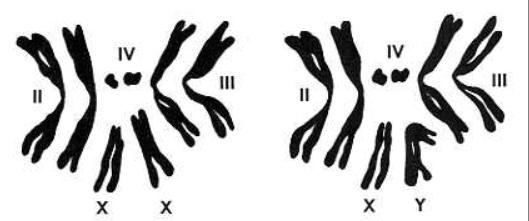

#### Using SeqIO

In [14]:
fly1_subsequences = read_and_process_fasta_seqio("../../dmel-all-chromosome-r6.63.fasta", filter=["2R", "2L", "X", "Y", "3R", "3L", "4"], exact_match = True, allow_N=False)

Selected 100 non-overlapping sequences of length 50kb from the FASTA file.


#### Retrieve Nucleotide and Dinucleotide Counts from the Retrieved 100 50kbp Subsequences of the Fruit Fly Genome

In [ ]:
sequence_nucleotides = count_nucleotides(fly1_subsequences)

In [ ]:
sequence_dinucleotides = count_dinucleotides(fly1_subsequences)

In [ ]:
# remove from memory
del fly1_subsequences

Nucleotide counts are simply derived by counting the number of A's, C's, G's and T's in a particular 50kbp subsequence. This is defined in the helper function above. It is important to note that the headers signify the chromosome, start index, and end index—separated by underscores (chromosome_start_end), denoting where the subsequence was derived from the original sequence of the chromosome in the FASTA file. 

In [ ]:
fly1_df_nucleotides = pd.DataFrame(sequence_nucleotides).T
fly1_df_nucleotides.head()

,A,C,G,T
X_3735650_3785650,14376,9699,10088,15837
2L_9228452_9278452,14908,10537,10229,14326
2R_7489709_7539709,12907,11642,11895,13556
2R_24711873_24761873,14299,11515,11303,12883
2L_22706266_22756266,15124,9617,9898,15361


Dinucleotide counts are simply derived by counting the number of the 16 possible dinucleotide combination in a particular 50 kbp sequence, such that
ATCG would result to dinucleotide counts, AT-1, TC-1 and CG-1.

In [ ]:
fly1_df_dinucleotides = pd.DataFrame(sequence_dinucleotides).T
fly1_df_dinucleotides.head()

,AA,AC,AG,AT,CA,CC,CG,CT,GA,GC,GG,GT,TA,TC,TG,TT
X_3735650_3785650,5139,2563,2478,4195,3353,1879,1857,2610,2446,2522,2027,3093,3438,2734,3726,5939
2L_9228452_9278452,5464,2687,2632,4125,3663,2238,2021,2615,2503,3000,2195,2531,3278,2611,3381,5055
2R_7489709_7539709,3847,2652,2835,3572,3342,2498,2771,3031,3046,3400,2662,2787,2672,3092,3626,4166
2R_24711873_24761873,4887,2809,3070,3533,3701,2583,2355,2876,2963,3293,2625,2422,2748,2830,3252,4052
2L_22706266_22756266,5403,2597,2818,4305,3041,1923,1880,2773,2899,2181,2050,2768,3780,2916,3150,5515


#### Computing Nucleotide, Dinucleotide and Odd Ratio

The dinucleotide odds ratio can be deduced from the ratio of the observed and expected dinucleotide frequency. By computing Odd Ratio, we are trying to see which dinucleotides are underrepresented and overrepresented in Fruit Flies.
1. Odd Ratio < 1 : Underrepresented
2. Odd Ratio = 1 : Neither Underrepresented or Overrepresented
3. Odd Ratio > 1 : Overrepresented

Burge, C. B., Campbell, A., & Karlin, S. (1992). Over- and under-representation of short oligonucleotides in DNA sequences. Proceedings of the National Academy of Sciences of the United States of America, 89(4), 1358–1362. https://doi.org/10.1073/pnas.89.4.1358

In [ ]:
fly1_df_nucleotides["total_count_nucleotide"] = fly1_df_nucleotides[["A", "C", "G", "T"]].sum(axis=1)

In [ ]:
list_nucleotides = ['A', 'C', 'G', 'T']
for nucleotide in list_nucleotides:
    fly1_df_nucleotides["nuc_freq_" + nucleotide] = calculate_frequency_nucleotide(fly1_df_nucleotides, nucleotide)
fly1_df_nucleotides.head()

,A,C,G,T,total_count_nucleotide,nuc_freq_A,nuc_freq_C,nuc_freq_G,nuc_freq_T
X_3735650_3785650,14376,9699,10088,15837,50000,0.30213,0.19787,0.19787,0.30213
2L_9228452_9278452,14908,10537,10229,14326,50000,0.29234,0.20766,0.20766,0.29234
2R_7489709_7539709,12907,11642,11895,13556,50000,0.26463,0.23537,0.23537,0.26463
2R_24711873_24761873,14299,11515,11303,12883,50000,0.27182,0.22818,0.22818,0.27182
2L_22706266_22756266,15124,9617,9898,15361,50000,0.30485,0.19515,0.19515,0.30485


In [ ]:
list_dinucleotides = [
    'AA', 'AC', 'AG', 'AT',
    'CA', 'CC', 'CG', 'CT',
    'GA', 'GC', 'GG', 'GT',
    'TA', 'TC', 'TG', 'TT'
]
fly1_df_dinucleotides["total_count_dinucleotide"] = fly1_df_dinucleotides[list_dinucleotides].sum(axis=1)
fly1_df_dinucleotides.head()

,AA,AC,AG,AT,CA,CC,CG,CT,GA,GC,GG,GT,TA,TC,TG,TT,total_count_dinucleotide
X_3735650_3785650,5139,2563,2478,4195,3353,1879,1857,2610,2446,2522,2027,3093,3438,2734,3726,5939,49999
2L_9228452_9278452,5464,2687,2632,4125,3663,2238,2021,2615,2503,3000,2195,2531,3278,2611,3381,5055,49999
2R_7489709_7539709,3847,2652,2835,3572,3342,2498,2771,3031,3046,3400,2662,2787,2672,3092,3626,4166,49999
2R_24711873_24761873,4887,2809,3070,3533,3701,2583,2355,2876,2963,3293,2625,2422,2748,2830,3252,4052,49999
2L_22706266_22756266,5403,2597,2818,4305,3041,1923,1880,2773,2899,2181,2050,2768,3780,2916,3150,5515,49999


In [ ]:
for dinucleotide in list_dinucleotides:
    fly1_df_dinucleotides[f'dinuc_freq_{dinucleotide}'] = calculate_frequency_dinucleotide(fly1_df_dinucleotides, dinucleotide)
fly1_df_dinucleotides.head()

,AA,AC,AG,AT,CA,CC,CG,CT,GA,GC,...,dinuc_freq_CG,dinuc_freq_CT,dinuc_freq_GA,dinuc_freq_GC,dinuc_freq_GG,dinuc_freq_GT,dinuc_freq_TA,dinuc_freq_TC,dinuc_freq_TG,dinuc_freq_TT
X_3735650_3785650,5139,2563,2478,4195,3353,1879,1857,2610,2446,2522,...,0.037141,0.050881,0.051801,0.043791,0.039061,0.056561,0.076332,0.051801,0.070791,0.110782
2L_9228452_9278452,5464,2687,2632,4125,3663,2238,2021,2615,2503,3000,...,0.040421,0.052471,0.051141,0.050211,0.044331,0.052181,0.074031,0.051141,0.070441,0.105192
2R_7489709_7539709,3847,2652,2835,3572,3342,2498,2771,3031,3046,3400,...,0.055421,0.058661,0.061381,0.061711,0.051601,0.054391,0.062441,0.061381,0.069681,0.080132
2R_24711873_24761873,4887,2809,3070,3533,3701,2583,2355,2876,2963,3293,...,0.047101,0.059461,0.057931,0.056481,0.052081,0.052311,0.062811,0.057931,0.069531,0.089392
2L_22706266_22756266,5403,2597,2818,4305,3041,1923,1880,2773,2899,2181,...,0.037601,0.055911,0.058151,0.040611,0.039731,0.053651,0.080852,0.058151,0.061911,0.109182


In [ ]:
#merge the two dataframes
fly1_df_combined = pd.concat([fly1_df_nucleotides, fly1_df_dinucleotides], axis=1)
fly1_df_combined.head()

,A,C,G,T,total_count_nucleotide,nuc_freq_A,nuc_freq_C,nuc_freq_G,nuc_freq_T,AA,...,dinuc_freq_CG,dinuc_freq_CT,dinuc_freq_GA,dinuc_freq_GC,dinuc_freq_GG,dinuc_freq_GT,dinuc_freq_TA,dinuc_freq_TC,dinuc_freq_TG,dinuc_freq_TT
X_3735650_3785650,14376,9699,10088,15837,50000,0.30213,0.19787,0.19787,0.30213,5139,...,0.037141,0.050881,0.051801,0.043791,0.039061,0.056561,0.076332,0.051801,0.070791,0.110782
2L_9228452_9278452,14908,10537,10229,14326,50000,0.29234,0.20766,0.20766,0.29234,5464,...,0.040421,0.052471,0.051141,0.050211,0.044331,0.052181,0.074031,0.051141,0.070441,0.105192
2R_7489709_7539709,12907,11642,11895,13556,50000,0.26463,0.23537,0.23537,0.26463,3847,...,0.055421,0.058661,0.061381,0.061711,0.051601,0.054391,0.062441,0.061381,0.069681,0.080132
2R_24711873_24761873,14299,11515,11303,12883,50000,0.27182,0.22818,0.22818,0.27182,4887,...,0.047101,0.059461,0.057931,0.056481,0.052081,0.052311,0.062811,0.057931,0.069531,0.089392
2L_22706266_22756266,15124,9617,9898,15361,50000,0.30485,0.19515,0.19515,0.30485,5403,...,0.037601,0.055911,0.058151,0.040611,0.039731,0.053651,0.080852,0.058151,0.061911,0.109182


Odds Ratio for Dinucleotides

The odds ratio $\rho'_{xy}$ for a dinucleotide $𝑥y$ is defined as the ratio of its observed frequency to its expected frequency. Under the assumption that the occurrences of $x$ and $y$ are independent, the expected frequency of the pair $xy$ is $f'_xf'_y$. 

$f'_{xy}$ quantifies how often ${xy}$ actually appears in a given sequence than expected. 


In [ ]:
list_dinucleotides = [
    'AA', 'AC', 'AG', 'AT',
    'CA', 'CC', 'CG', 'CT',
    'GA', 'GC', 'GG', 'GT',
    'TA', 'TC', 'TG', 'TT'
]

for dinucleotide in list_dinucleotides:
    fly1_df_combined[f"odds_ratio_{dinucleotide}"] = calculate_odds_ratio(fly1_df_combined, dinucleotide)
fly1_df_combined.head()

,A,C,G,T,total_count_nucleotide,nuc_freq_A,nuc_freq_C,nuc_freq_G,nuc_freq_T,AA,...,odds_ratio_CG,odds_ratio_CT,odds_ratio_GA,odds_ratio_GC,odds_ratio_GG,odds_ratio_GT,odds_ratio_TA,odds_ratio_TC,odds_ratio_TG,odds_ratio_TT
X_3735650_3785650,14376,9699,10088,15837,50000,0.30213,0.19787,0.19787,0.30213,5139,...,0.948617,0.851103,0.866492,1.118468,0.997656,0.946116,0.836212,0.866492,1.184150,1.213619
2L_9228452_9278452,14908,10537,10229,14326,50000,0.29234,0.20766,0.20766,0.29234,5464,...,0.937345,0.864328,0.842419,1.164376,1.028018,0.859551,0.866243,0.842419,1.160344,1.230854
2R_7489709_7539709,12907,11642,11895,13556,50000,0.26463,0.23537,0.23537,0.26463,3847,...,1.000398,0.941804,0.985474,1.113941,0.931443,0.873248,0.891648,0.985474,1.118734,1.144263
2R_24711873_24761873,14299,11515,11303,12883,50000,0.27182,0.22818,0.22818,0.27182,4887,...,0.904637,0.958682,0.934014,1.084796,1.000287,0.843402,0.850109,0.934014,1.121042,1.209859
2L_22706266_22756266,15124,9617,9898,15361,50000,0.30485,0.19515,0.19515,0.30485,5403,...,0.987323,0.939817,0.977470,1.066362,1.043254,0.901828,0.869994,0.977470,1.040674,1.174842


#### Plotting

In [ ]:
fly1_df_odd_ratio = fly1_df_combined.loc[:, fly1_df_combined.columns.str.startswith('odds_ratio_')]
fly1_df_odd_ratio.columns = fly1_df_odd_ratio.columns.str.replace('odds_ratio_', '', regex=True)
fly1_df_odd_ratio.head()

,AA,AC,AG,AT,CA,CC,CG,CT,GA,GC,GG,GT,TA,TC,TG,TT
X_3735650_3785650,1.213619,0.946116,0.851103,0.836212,1.184150,0.997656,0.948617,0.851103,0.866492,1.118468,0.997656,0.946116,0.836212,0.866492,1.184150,1.213619
2L_9228452_9278452,1.230854,0.859551,0.864328,0.866243,1.160344,1.028018,0.937345,0.864328,0.842419,1.164376,1.028018,0.859551,0.866243,0.842419,1.160344,1.230854
2R_7489709_7539709,1.144263,0.873248,0.941804,0.891648,1.118734,0.931443,1.000398,0.941804,0.985474,1.113941,0.931443,0.873248,0.891648,0.985474,1.118734,1.144263
2R_24711873_24761873,1.209859,0.843402,0.958682,0.850109,1.121042,1.000287,0.904637,0.958682,0.934014,1.084796,1.000287,0.843402,0.850109,0.934014,1.121042,1.209859
2L_22706266_22756266,1.174842,0.901828,0.939817,0.869994,1.040674,1.043254,0.987323,0.939817,0.977470,1.066362,1.043254,0.901828,0.869994,0.977470,1.040674,1.174842


In [ ]:
fly1_mean_odds_ratios = fly1_df_odd_ratio.mean()

Text(0, 0.5, 'Mean Odds Ratio')

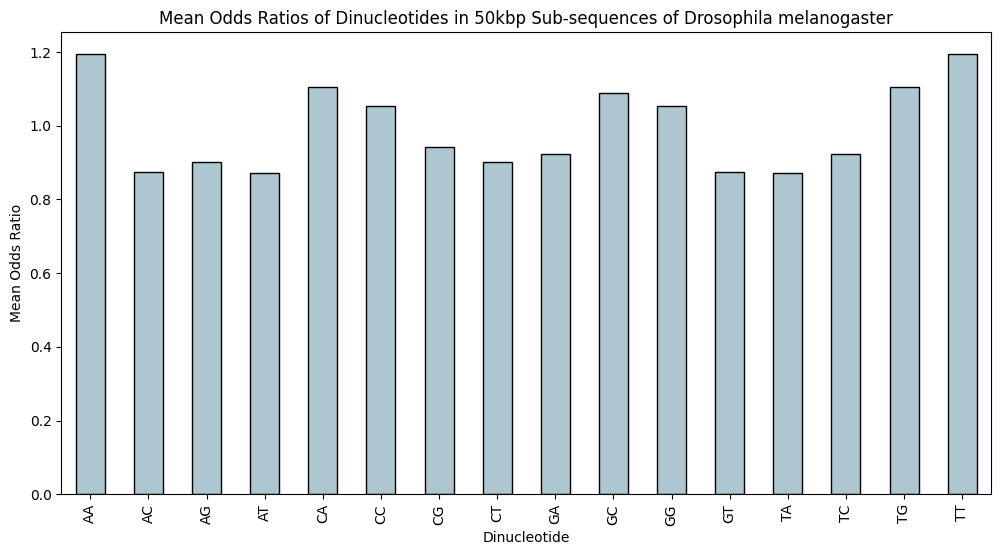

In [ ]:
plt.figure(figsize=(12, 6))
fly1_mean_odds_ratios.plot(kind='bar', color='#AEC6CF', edgecolor='black')
plt.title("Mean Odds Ratios of Dinucleotides in 50kbp Sub-sequences of Drosophila melanogaster")
plt.xlabel("Dinucleotide")
plt.ylabel("Mean Odds Ratio")

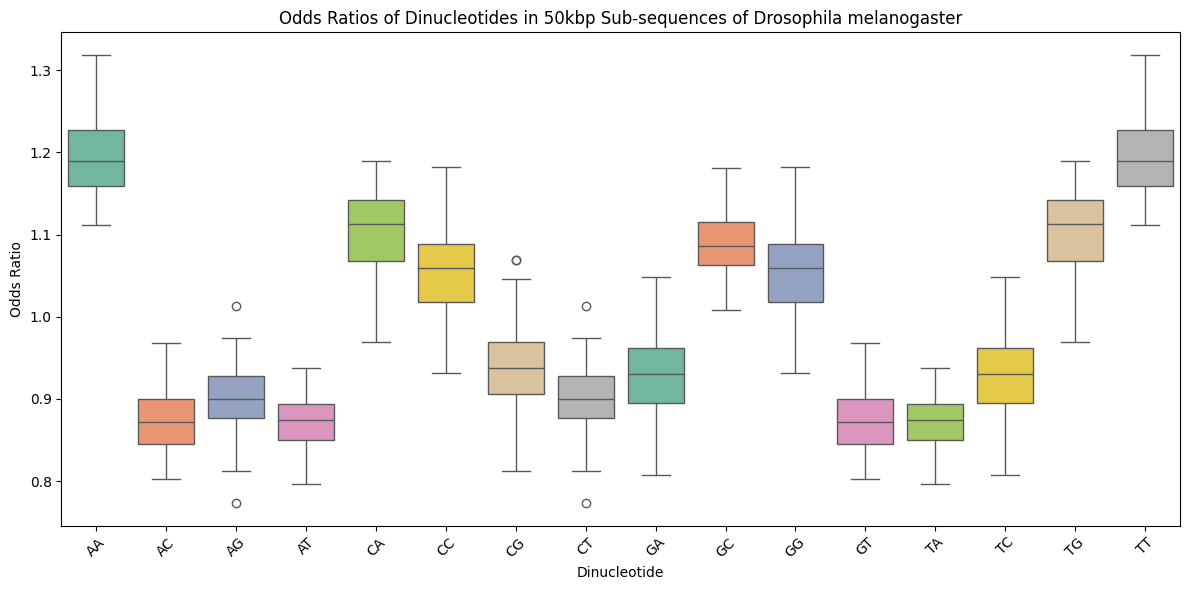

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=fly1_df_odd_ratio, palette="Set2")
plt.title("Odds Ratios of Dinucleotides in 50kbp Sub-sequences of Drosophila melanogaster")
plt.xlabel("Dinucleotide")
plt.ylabel("Odds Ratio")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Analysis
Drosophila all exhibit a moderate spread in all values.

We want to focus our discussion on moderately over-represented dinucleotides AA and TT and moderately under-represented dinucleotides AT, TA, GT and AC.

##### Biological Implications
Karlin and Mrazek's genome heterogeneity paper quantified the modestly under-represented nature of AT, TA, GT and AC dinucleotides. TA is prominent in essential signals like the TATA box (transcription initiation) and the 3' polyadenylation signal (transcription termination). TA suppression could help prevent false regulatory signals throughout the genome. AC and GT are crucial in splicing signals. Similar to the TATA box explanation for TA, it is suggested that these dinucleotides may be maintained at a low frequency to avoid false splicing signals, reducing intron-splicing options in candidate primary mRNA sequences. [1] 

Both AA and TT dinucleotides belong to the Weak-Weak types of dinucleotides [2]. These family of dinucleotides are intrinsically bendable. This bendable nature makes it useful for wrapping DNA around their histones which reduces the overall energetic cost of bending the DNA. This is further supported by genome-wide maps of Drosophilia in which a ~10 bp oscillation of AA/TT occurs as DNA tends to warp every 10bp as well. [3] [4]

[1] Karlin, S., Ladunga, I., & Blaisdell, B. E. (1994). Heterogeneity of genomes: Measures and values. Proceedings of the National Academy of Sciences of the United States of America, 91(26), 12837–12841. https://doi.org/10.1073/pnas.91.26.12837

[2] Laurent Duret, Nicolas Galtier, The Covariation Between TpA Deficiency, CpG Deficiency, and G+C Content of Human Isochores Is Due to a Mathematical Artifact, Molecular Biology and Evolution, Volume 17, Issue 11, November 2000, Pages 1620–1625, https://doi.org/10.1093/oxfordjournals.molbev.a026261

[3] Ioshikhes, I., Hosid, S., & Pugh, B. F. (2011). Variety of genomic DNA patterns for nucleosome positioning. Genome research, 21(11), 1863–1871. https://doi.org/10.1101/gr.116228.110

[4] Hebert, C., Roest Crollius, H. Nucleosome rotational setting is associated with transcriptional regulation in promoters of tissue-specific human genes. Genome Biol 11, R51 (2010). https://doi.org/10.1186/gb-2010-11-5-r51

## Investigating the Human Genome

Sequencing the human genome is one of the most monumental achievements of the 21st century. The haploid human genome comprises approximately 2.85 billion base pairs organized into 23 chromosomes. This vast repository of genetic information serves as the foundational reference for countless studies in genetics, evolution and medical research.

One of the unique features of the human genome is its compositional heterogeneity, including regions of varying GC di-nucleotide content known as isochores. In particular, these CG dinucleotides occur at less than one-fifth of their expected frequency in the human genome due to the high mutation rate of methylated cytosine and its subsequent deamination.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/5b/Cytosine_becomes_thymine.png/1200px-Cytosine_becomes_thymine.png"/>

This under-representation of CG nucleotides is futher modulated by the presence of CpG islands, which are short regions within the genome which have higher CpG density near gene promoters. These islands play a key role in epigenetics.

Analyzing dinucleotide frequencies across random DNA segments provide insights into the various biases within a given genomic sequence. These biases could have been introduced through varying methylation patterns, mutational mechanisms or evolutionary pressures, such as the case for the presence of CpG islands. The analysis as well as the biological implication of these CpG would be detailed at a later section of this notebook.

Similar to the investigation of Drosophilia earlier, we analyzed random 50kbp subsequences of the human genome. From this, we could analyze which compositional biases in dinucleotides are similar and/or different between fruit flies and humans. 

Lander, E. S., Linton, L. M., Birren, B., Nusbaum, C., Zody, M. C., Baldwin, J., Devon, K., Dewar, K., Doyle, M., FitzHugh, W., Funke, R., Gage, D., Harris, K., Heaford, A., Howland, J., Kann, L., Lehoczky, J., LeVine, R., McEwan, P., McKernan, K., … International Human Genome Sequencing Consortium (2001). Initial sequencing and analysis of the human genome. Nature, 409(6822), 860–921. https://doi.org/10.1038/35057062

#### Using SeqIO

In [ ]:
human_subsequences = read_and_process_fasta_seqio("GRCh38.p14.genome.fa", filter=["chr"], exact_match= False, allow_N=False)

Selected 100 non-overlapping sequences of length 50kb from the FASTA file.


#### Count Nucleotide and Dinucleotide Counts

Nucleotide counts are simply derived by counting the number of A's, C's, G's and T's in a particular 50kbp subsequence. This is defined in the helper function above. It is important to note that the headers signify the chromosome, start index, and end index—separated by underscores (chromosome_start_end), denoting where the subsequence was derived from the original sequence of the chromosome in the FASTA file. 

In [ ]:
sequence_nucleotides = count_nucleotides(human_subsequences)

As defined in the helper function above, dinucleotide counts are simply derived by counting the number of the 16 possible dinucleotide combination in a particular 50 kbp sequence, such that ATCG would result to dinucleotide counts, AT-1, TC-1 and CG-1.

In [ ]:
sequence_dinucleotides = count_dinucleotides(human_subsequences)

In [ ]:
# remove from memory
del human_subsequences

In [ ]:
human_df_nucleotides = pd.DataFrame(sequence_nucleotides).T
human_df_nucleotides.head()

,A,C,G,T
chr21_18456905_18506905,16755,8579,8758,15908
chr8_59917677_59967677,16319,8874,9240,15567
chr5_27513338_27563338,15801,8656,9024,16519
chr22_49705370_49755370,12432,13025,12258,12285
chr18_11668732_11718732,13563,10650,11136,14651


In [ ]:
human_df_dinucleotides = pd.DataFrame(sequence_dinucleotides).T
human_df_dinucleotides.head()

,AA,AC,AG,AT,CA,CC,CG,CT,GA,GC,GG,GT,TA,TC,TG,TT
chr21_18456905_18506905,5955,2557,3310,4933,3543,1706,293,3037,2999,1509,1907,2342,4257,2807,3248,5596
chr8_59917677_59967677,5793,2538,3387,4601,3579,1853,314,3128,3020,1706,2110,2403,3927,2777,3429,5434
chr5_27513338_27563338,5390,2401,3040,4969,3418,1848,261,3129,2785,1608,2003,2628,4208,2799,3719,5793
chr22_49705370_49755370,3441,2606,3759,2626,4061,4279,1063,3621,3095,3032,3719,2412,1834,3108,3717,3626
chr18_11668732_11718732,4133,2434,3564,3432,3636,2705,748,3560,2951,2510,2973,2702,2843,3000,3851,4957


#### Computing Nucleotide, Dinucleotide and Odd Ratio

Similar to what we did for Fruit Flies, the dinucleotide odds ratio can be deduced from the ratio of the observed and expected dinucleotide frequency. By computing Odd Ratio, we are trying to see what is underrepresented and overrepresented in Humans.
1. Odd Ratio < 1 : Underrepresented
2. Odd Ratio = 1 : Neither Underrepresented or Overrepresented
3. Odd Ratio > 1 : Overrepresented

Burge, C. B., Campbell, A., & Karlin, S. (1992). Over- and under-representation of short oligonucleotides in DNA sequences. Proceedings of the National Academy of Sciences of the United States of America, 89(4), 1358–1362. https://doi.org/10.1073/pnas.89.4.1358

In [ ]:
list_nucleotides = ['A', 'C', 'G', 'T']
human_df_nucleotides["total_count_nucleotide"] = human_df_nucleotides[list_nucleotides].sum(axis=1)
human_df_nucleotides.head()

,A,C,G,T,total_count_nucleotide
chr21_18456905_18506905,16755,8579,8758,15908,50000
chr8_59917677_59967677,16319,8874,9240,15567,50000
chr5_27513338_27563338,15801,8656,9024,16519,50000
chr22_49705370_49755370,12432,13025,12258,12285,50000
chr18_11668732_11718732,13563,10650,11136,14651,50000


In [ ]:
for nucleotide in list_nucleotides:
    human_df_nucleotides["nuc_freq_" + nucleotide] = calculate_frequency_nucleotide(human_df_nucleotides, nucleotide)
human_df_nucleotides.head()

,A,C,G,T,total_count_nucleotide,nuc_freq_A,nuc_freq_C,nuc_freq_G,nuc_freq_T
chr21_18456905_18506905,16755,8579,8758,15908,50000,0.32663,0.17337,0.17337,0.32663
chr8_59917677_59967677,16319,8874,9240,15567,50000,0.31886,0.18114,0.18114,0.31886
chr5_27513338_27563338,15801,8656,9024,16519,50000,0.32320,0.17680,0.17680,0.32320
chr22_49705370_49755370,12432,13025,12258,12285,50000,0.24717,0.25283,0.25283,0.24717
chr18_11668732_11718732,13563,10650,11136,14651,50000,0.28214,0.21786,0.21786,0.28214


In [ ]:
list_dinucleotides = [
    'AA', 'AC', 'AG', 'AT',
    'CA', 'CC', 'CG', 'CT',
    'GA', 'GC', 'GG', 'GT',
    'TA', 'TC', 'TG', 'TT'
]
human_df_dinucleotides["total_count_dinucleotide"] = human_df_dinucleotides[list_dinucleotides].sum(axis=1)
human_df_dinucleotides.head()

,AA,AC,AG,AT,CA,CC,CG,CT,GA,GC,GG,GT,TA,TC,TG,TT,total_count_dinucleotide
chr21_18456905_18506905,5955,2557,3310,4933,3543,1706,293,3037,2999,1509,1907,2342,4257,2807,3248,5596,49999
chr8_59917677_59967677,5793,2538,3387,4601,3579,1853,314,3128,3020,1706,2110,2403,3927,2777,3429,5434,49999
chr5_27513338_27563338,5390,2401,3040,4969,3418,1848,261,3129,2785,1608,2003,2628,4208,2799,3719,5793,49999
chr22_49705370_49755370,3441,2606,3759,2626,4061,4279,1063,3621,3095,3032,3719,2412,1834,3108,3717,3626,49999
chr18_11668732_11718732,4133,2434,3564,3432,3636,2705,748,3560,2951,2510,2973,2702,2843,3000,3851,4957,49999


In [ ]:
for dinucleotide in list_dinucleotides:
    human_df_dinucleotides[f'dinuc_freq_{dinucleotide}'] = calculate_frequency_dinucleotide(human_df_dinucleotides, dinucleotide)

human_df_dinucleotides.head()

,AA,AC,AG,AT,CA,CC,CG,CT,GA,GC,...,dinuc_freq_CG,dinuc_freq_CT,dinuc_freq_GA,dinuc_freq_GC,dinuc_freq_GG,dinuc_freq_GT,dinuc_freq_TA,dinuc_freq_TC,dinuc_freq_TG,dinuc_freq_TT
chr21_18456905_18506905,5955,2557,3310,4933,3543,1706,293,3037,2999,1509,...,0.00586,0.063471,0.058061,0.018020,0.036131,0.048991,0.091902,0.058061,0.067911,0.115512
chr8_59917677_59967677,5793,2538,3387,4601,3579,1853,314,3128,3020,1706,...,0.00628,0.065151,0.057971,0.020200,0.039631,0.049411,0.085282,0.057971,0.070081,0.112272
chr5_27513338_27563338,5390,2401,3040,4969,3418,1848,261,3129,2785,1608,...,0.00522,0.061691,0.055841,0.018690,0.038511,0.050291,0.091772,0.055841,0.071371,0.111832
chr22_49705370_49755370,3441,2606,3759,2626,4061,4279,1063,3621,3095,3032,...,0.02126,0.073801,0.062031,0.040951,0.079982,0.050181,0.044601,0.062031,0.077782,0.070671
chr18_11668732_11718732,4133,2434,3564,3432,3636,2705,748,3560,2951,2510,...,0.01496,0.071241,0.059511,0.032581,0.056781,0.051361,0.062751,0.059511,0.074871,0.090902


In [ ]:
#merge the two dataframes
human_df_combined = pd.concat([human_df_nucleotides, human_df_dinucleotides], axis=1)
human_df_combined.head()

,A,C,G,T,total_count_nucleotide,nuc_freq_A,nuc_freq_C,nuc_freq_G,nuc_freq_T,AA,...,dinuc_freq_CG,dinuc_freq_CT,dinuc_freq_GA,dinuc_freq_GC,dinuc_freq_GG,dinuc_freq_GT,dinuc_freq_TA,dinuc_freq_TC,dinuc_freq_TG,dinuc_freq_TT
chr21_18456905_18506905,16755,8579,8758,15908,50000,0.32663,0.17337,0.17337,0.32663,5955,...,0.00586,0.063471,0.058061,0.018020,0.036131,0.048991,0.091902,0.058061,0.067911,0.115512
chr8_59917677_59967677,16319,8874,9240,15567,50000,0.31886,0.18114,0.18114,0.31886,5793,...,0.00628,0.065151,0.057971,0.020200,0.039631,0.049411,0.085282,0.057971,0.070081,0.112272
chr5_27513338_27563338,15801,8656,9024,16519,50000,0.32320,0.17680,0.17680,0.32320,5390,...,0.00522,0.061691,0.055841,0.018690,0.038511,0.050291,0.091772,0.055841,0.071371,0.111832
chr22_49705370_49755370,12432,13025,12258,12285,50000,0.24717,0.25283,0.25283,0.24717,3441,...,0.02126,0.073801,0.062031,0.040951,0.079982,0.050181,0.044601,0.062031,0.077782,0.070671
chr18_11668732_11718732,13563,10650,11136,14651,50000,0.28214,0.21786,0.21786,0.28214,4133,...,0.01496,0.071241,0.059511,0.032581,0.056781,0.051361,0.062751,0.059511,0.074871,0.090902


Odds Ratio for Dinucleotides

The odds ratio $\rho'_{xy}$ for a dinucleotide $𝑥y$ is defined as the ratio of its observed frequency to its expected frequency. Under the assumption that the occurrences of $x$ and $y$ are independent, the expected frequency of the pair $xy$ is $f'_xf'_y$. 

$f'_{xy}$ quantifies how often ${xy}$ actually appears in a given sequence than expected. 


In [ ]:
list_dinucleotides = [
    'AA', 'AC', 'AG', 'AT',
    'CA', 'CC', 'CG', 'CT',
    'GA', 'GC', 'GG', 'GT',
    'TA', 'TC', 'TG', 'TT'
]

for dinucleotide in list_dinucleotides:
    human_df_combined[f"odds_ratio_{dinucleotide}"] = calculate_odds_ratio(human_df_combined, dinucleotide)
human_df_combined.head()

,A,C,G,T,total_count_nucleotide,nuc_freq_A,nuc_freq_C,nuc_freq_G,nuc_freq_T,AA,...,odds_ratio_CG,odds_ratio_CT,odds_ratio_GA,odds_ratio_GC,odds_ratio_GG,odds_ratio_GT,odds_ratio_TA,odds_ratio_TC,odds_ratio_TG,odds_ratio_TT
chr21_18456905_18506905,16755,8579,8758,15908,50000,0.32663,0.17337,0.17337,0.32663,5955,...,0.194966,1.120849,1.025311,0.599536,1.202067,0.865139,0.861414,1.025311,1.199257,1.082720
chr8_59917677_59967677,16319,8874,9240,15567,50000,0.31886,0.18114,0.18114,0.31886,5793,...,0.191399,1.127999,1.003685,0.615646,1.207825,0.855479,0.838795,1.003685,1.213356,1.104263
chr5_27513338_27563338,15801,8656,9024,16519,50000,0.32320,0.17680,0.17680,0.32320,5390,...,0.166999,1.079617,0.977238,0.597934,1.232020,0.880109,0.878550,0.977238,1.249024,1.070593
chr22_49705370_49755370,12432,13025,12258,12285,50000,0.24717,0.25283,0.25283,0.24717,3441,...,0.332594,1.180975,0.992627,0.640627,1.251218,0.802999,0.730049,0.992627,1.244664,1.156784
chr18_11668732_11718732,13563,10650,11136,14651,50000,0.28214,0.21786,0.21786,0.28214,4133,...,0.315199,1.159019,0.968181,0.686443,1.196325,0.835587,0.788303,0.968181,1.218076,1.141940


#### Plotting

In [ ]:
human_df_odd_ratio = human_df_combined.loc[:, human_df_combined.columns.str.startswith('odds_ratio_')]
human_df_odd_ratio.columns = human_df_odd_ratio.columns.str.replace('odds_ratio_', '', regex=True)
human_df_odd_ratio.head()

,AA,AC,AG,AT,CA,CC,CG,CT,GA,GC,GG,GT,TA,TC,TG,TT
chr21_18456905_18506905,1.082720,0.865139,1.120849,0.861414,1.199257,1.202067,0.194966,1.120849,1.025311,0.599536,1.202067,0.865139,0.861414,1.025311,1.199257,1.082720
chr8_59917677_59967677,1.104263,0.855479,1.127999,0.838795,1.213356,1.207825,0.191399,1.127999,1.003685,0.615646,1.207825,0.855479,0.838795,1.003685,1.213356,1.104263
chr5_27513338_27563338,1.070593,0.880109,1.079617,0.878550,1.249024,1.232020,0.166999,1.079617,0.977238,0.597934,1.232020,0.880109,0.878550,0.977238,1.249024,1.070593
chr22_49705370_49755370,1.156784,0.802999,1.180975,0.730049,1.244664,1.251218,0.332594,1.180975,0.992627,0.640627,1.251218,0.802999,0.730049,0.992627,1.244664,1.156784
chr18_11668732_11718732,1.141940,0.835587,1.159019,0.788303,1.218076,1.196325,0.315199,1.159019,0.968181,0.686443,1.196325,0.835587,0.788303,0.968181,1.218076,1.141940


In [ ]:
human_mean_odds_ratios = human_df_odd_ratio.mean()

Text(0, 0.5, 'Mean Odds Ratio')

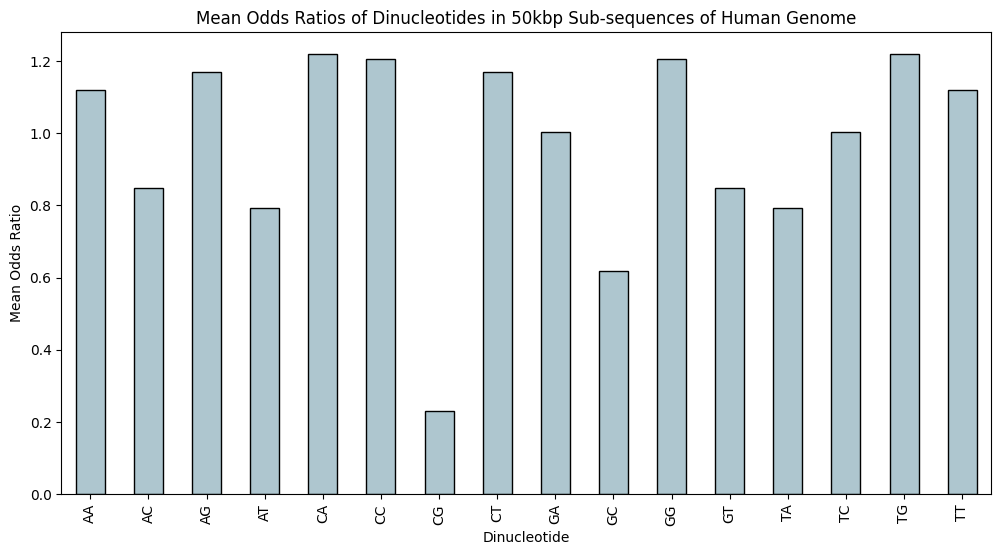

In [ ]:
plt.figure(figsize=(12, 6))
human_mean_odds_ratios.plot(kind='bar', color='#AEC6CF', edgecolor='black')
plt.title("Mean Odds Ratios of Dinucleotides in 50kbp Sub-sequences of Human Genome")
plt.xlabel("Dinucleotide")
plt.ylabel("Mean Odds Ratio")

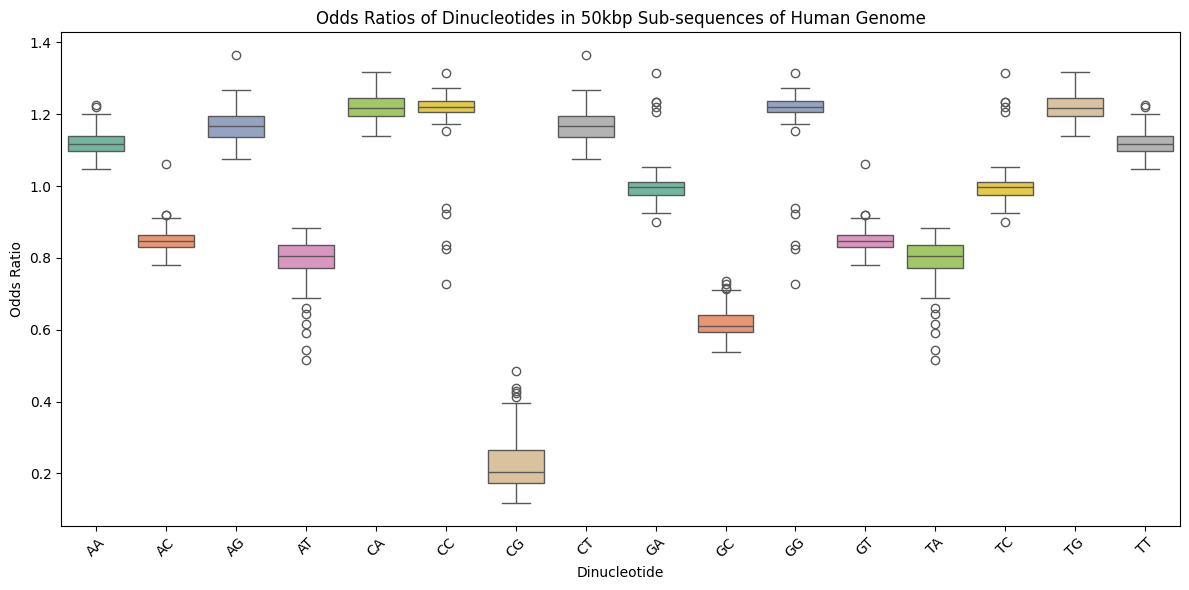

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=human_df_odd_ratio, palette="Set2")
plt.title("Odds Ratios of Dinucleotides in 50kbp Sub-sequences of Human Genome")
plt.xlabel("Dinucleotide")
plt.ylabel("Odds Ratio")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Analysis
The given odd-ratios show that both CG and GC are the most under-represented while both CA and TG  are the most over-represented. The under-representation of the CG dinucleotide represents the phenomenon of CpG islands.

### CpG Islands
A CpG island refers to the islands of the CG dinucleotide scattered throughout the human genome. The "p" refers to the phosphodiester bond between two dinucleotides, hence is is usually referred to as "CpG". These islands are typically 500-1500bp long [1]. In most vertebrates such as mammals, CpG dinucleotides are rare (less than 25% of the predicted frequency) because 70 of all the cytosines in the CG dinucleotide are methylated [2]. These cytosines (referred to as 5-methylcytosine, see notes below) deaminates to thymine faster than unmethylated cytosine. This deamnation of the methylated cytosine converts CpG to TpG/CpA which drives the genome-wide CpG depletion while both TG and CA dinucleotides are enriched [3].

<img src=https://www.researchgate.net/publication/263276528/figure/fig1/AS:296482692452357@1447698390493/Methylated-CPG-sites.png/ >

CpG islands frequently overlap with the promoter regions of genes. Their unmethylated state recruits transcription factors and other complexes which create an environment needed for binding RNA polymerase II and transcription initiation [4]. Furthermore, they also handle tissue-specific expression. Some tissue-specific genes have CPG islands in distal regulatory regions that fine-tune gene expression patterns. 

### Important Terms to Note
1. **Methylation**: refers to the addition of a methyl group ($-CH_3$) onto a molecule without changing its core structure. Given that cytosine’s C5 carbon is part of a stable aromatic ring, it cannot directly grab a methyl group. Instead, DNA methyltransferase (DNMT) enzymes temporarily attach to cytosine, using a cysteine in the enzyme to break the ring’s aromaticity and make C5 reactive. Once C5 is activated, it takes a methyl from S-adenosylmethionine (SAM), and the enzyme then lets go, restoring the ring and yielding 5-methylcytosine. 
2. **Distal Regulatory Regions**: Refers to regions of DNA located kilobases or megabases away from the promoters of the genes they want to regulate. These include enhancers, silencers, insulators and locus control regions each of which recruits specific transcription factors or chromatin‐modifying complexes to modulate transcriptional activity at a distance

[1] Jung, M., & Pfeifer, G. P. (2013). CpG islands. In S. Maloy & K. Hughes (Eds.), Brenner's Encyclopedia of Genetics (2nd ed., pp. 205-207). Academic Press. https://doi.org/10.1016/B978-0-12-374984-0.00349-1

[2] Strichman-Almashanu, L. Z., Lee, R. S., Onyango, P. O., Perlman, E., Flam, F., Frieman, M. B., & Feinberg, A. P. (2002). A genome-wide screen for normally methylated human CpG islands that can identify novel imprinted genes. Genome research, 12(4), 543–554. https://doi.org/10.1101/gr.224102

[3] Bird A. P. (1980). DNA methylation and the frequency of CpG in animal DNA. Nucleic acids research, 8(7), 1499–1504. https://doi.org/10.1093/nar/8.7.1499

[4] Thomson, J. P., Skene, P. J., Selfridge, J., Clouaire, T., Guy, J., Webb, S., Kerr, A. R., Deaton, A., Andrews, R., James, K. D., Turner, D. J., Illingworth, R., & Bird, A. (2010). CpG islands influence chromatin structure via the CpG-binding protein Cfp1. Nature, 464(7291), 1082–1086. https://doi.org/10.1038/nature08924

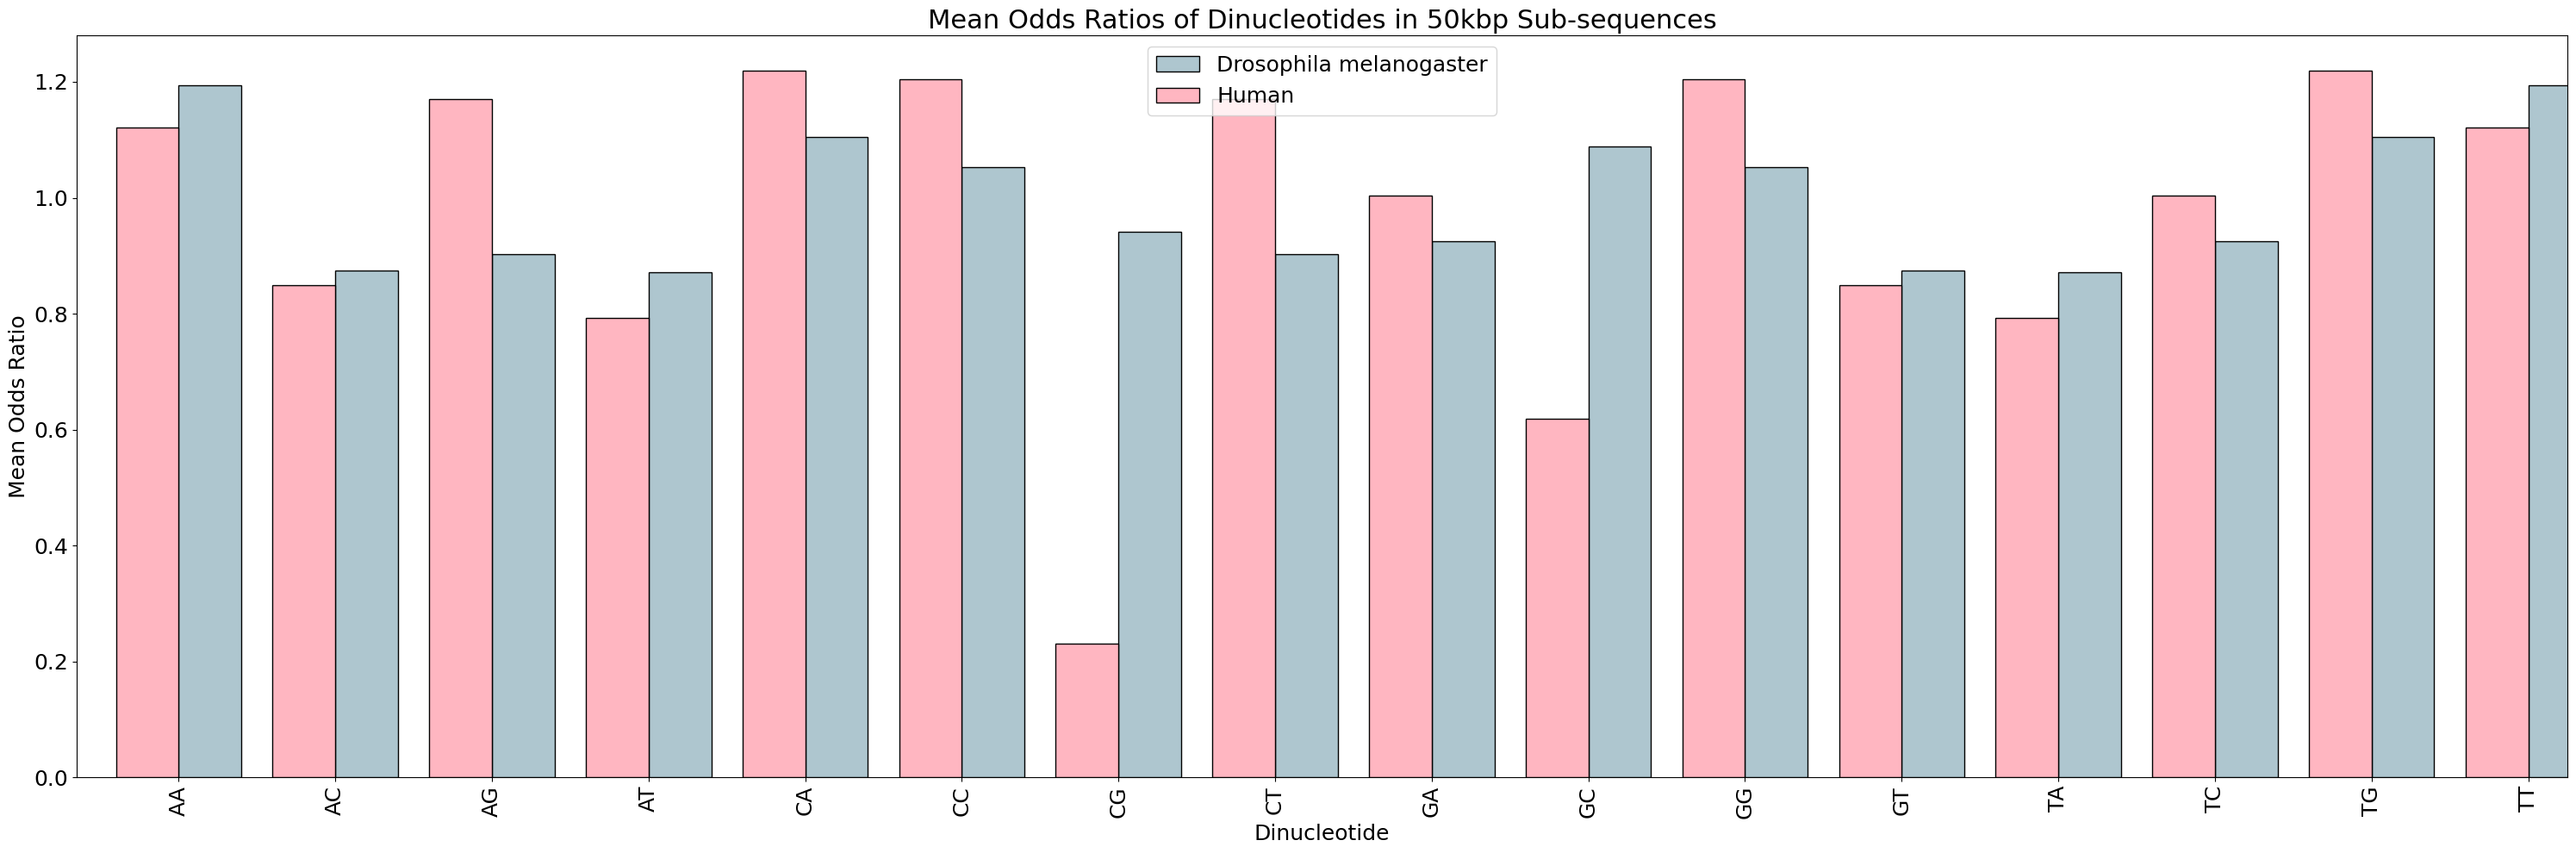

In [ ]:
plt.figure(figsize=(30, 10))
ax = fly1_mean_odds_ratios.plot(kind='bar', color='#AEC6CF', edgecolor='black', position=0, width=0.4, label='Drosophila melanogaster')
human_mean_odds_ratios.plot(kind='bar', color='#FFB6C1', edgecolor='black', position=1, width=0.4, label='Human', ax=ax)
plt.title("Mean Odds Ratios of Dinucleotides in 50kbp Sub-sequences", fontsize=22)
plt.xlabel("Dinucleotide", fontsize =18)
plt.ylabel("Mean Odds Ratio", fontsize=18)
plt.xticks(rotation=90, size=18)
plt.yticks(size=18)
plt.legend(fontsize=18)
plt.tight_layout()
plt.show()

## Side by Side Comparison
The plot above shows the mean odds ratios of dinucleotides between humans and fruit flies. As discussed earlier, the following patterns stand out:

| Dinucleotide | Human (pink)             | Fly (blue)                                                                                                                | Interpretation                                                                                                            |
| ------------ | ------------------------ | ------------------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------- |
| **CG**       | **≈ 0.2**  | ≈ 0.9                                                                                                                     | *Severe under-representation in human only.* Hallmark of CpG methylation and subsequent deamination.                                   |
| **CA / TG**  | ≈ 1.2                    | ≈ 1.05                                                                                                                    | **Over-representation in human.** These are the direct mutational products of CG loss (C->T on one strand, G->A on the other). |
| **GC**       | \~0.60–0.80            | ≈ 1.05                                                                                                                    | Slight under-representation in human
| **TA/AT**       | \~0.8–0.85| \~0.8–0.85| Slight under-representation in both species |                                                                                                                           |
| **AA / TT**  | \~1.1–1.15               | \~1.15–1.2                                                                                         | Slight enrichment—common in many eukaryotes because AAA/TTT tracts bend DNA and aid nucleosome positioning.               |

It should be noted that similar to fruit files, the human genome also has slight AA/TT enrichment. 

Furthermore, both human and fruit fly genome also have under-represented AT dinucleotides which suggests that both genomes tend to avoid building it due to its intrinsically unstable nature.  AT-dinucleotide rich sequences drive fragile site formation such that AT-dinucleotide rich sequences have the potential to form secondary structures upon unwinding the double helix during DNA replication, which can disrupt the progression of DNA replication and lead to genomic instability [2].

TA is moderately suppressed in both humans and fruit flies, matching findings of Gentles & Karlin (2001) that TA pairs are often avoided in coding and non-coding regions. TA is found in regulatory signals such as TATA Box and 3-polyadenylation signal. Avoiding the false activation of regulatory signals could contribute to TA suppression [1]. 

AC/GT, AA/TT, and AT/TA mean odd ratio do not differ much between Human and Fruit Fly and are generally neither under or over-represented.

[1] Gentles, A. J., & Karlin, S. (2001). Genome-scale compositional comparisons in eukaryotes. Genome research, 11(4), 540–546. https://doi.org/10.1101/gr.163101

[2] Irony-Tur Sinai, M., Salamon, A., Stanleigh, N., Goldberg, T., Weiss, A., Wang, Y. H., & Kerem, B. (2019). AT-dinucleotide rich sequences drive fragile site formation. Nucleic acids research, 47(18), 9685–9695. https://doi.org/10.1093/nar/gkz689